In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.patches as patches

In [2]:
plt.style.use('/home/luuk/Documents/MNRAS_stylesheet')

In [3]:
future_NL_GDP = pd.read_csv('./predicted_GDP_future.csv')
future_NL_GDP = future_NL_GDP[['TIME','Value']]
future_NL_GDP['Growth'] = future_NL_GDP.Value.pct_change()+1
future_NL_GDP = future_NL_GDP.set_index('TIME')
future_NL_GDP.loc[2020,'Growth'] = future_NL_GDP.Growth.mean()
future_NL_GDP.Growth = future_NL_GDP.Growth-0.01

In [4]:
future_NL_GDP['r1'] = 1-0.005
future_NL_GDP['r2'] = 1
future_NL_GDP['r3'] = future_NL_GDP.Growth
future_NL_GDP['r4'] = 1+0.01
future_NL_GDP['r5'] = 1+0.03

In [5]:
def debt_progress(df):
    df.columns = ['Growth','Rate']
    df['debt'] = 0
    df.loc[2020,'debt'] = 68.51
    for year in df.index[:-1]:
        g = df.loc[year,'Growth']
        r = df.loc[year,'Rate']
        df.loc[year+1,'debt'] = df.loc[year,'debt'] *(1/g)*r 
    return df

<ipython-input-5-28fa2bf12c39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['debt'] = 0
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


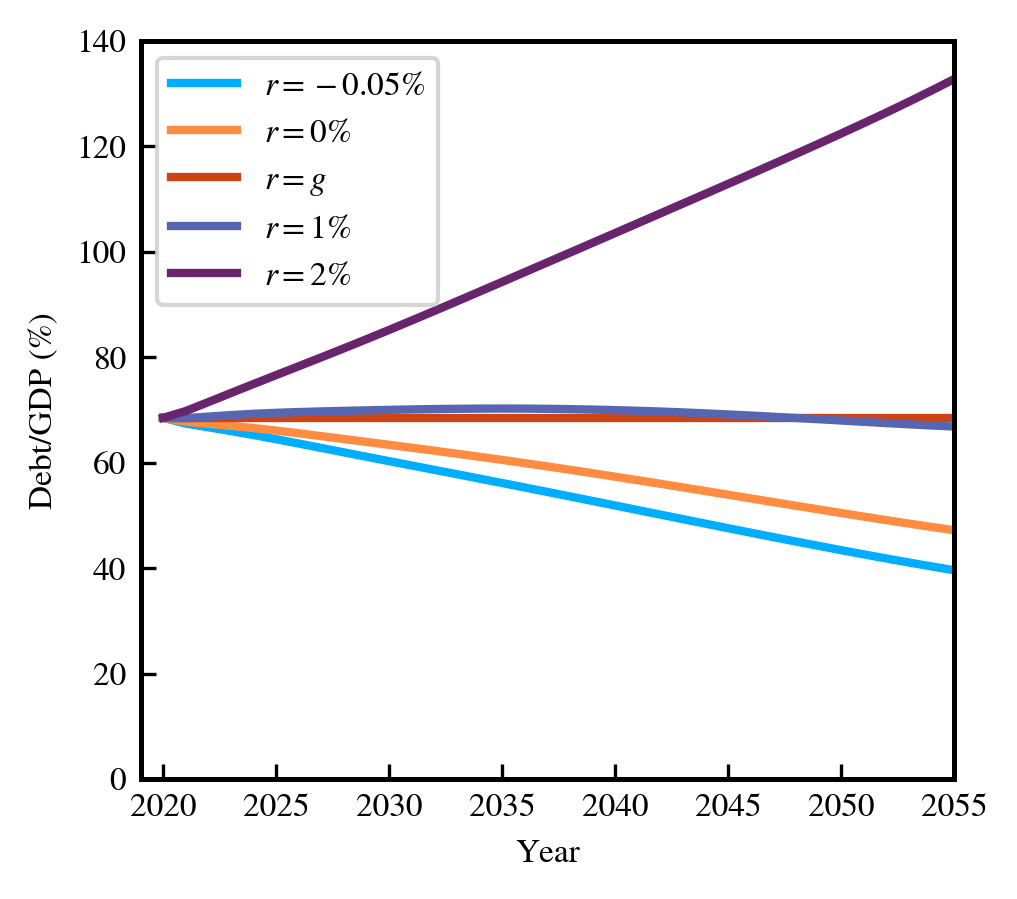

In [6]:
df1 = debt_progress(future_NL_GDP[['Growth','r1']])
df2 = debt_progress(future_NL_GDP[['Growth','r2']])
df3 = debt_progress(future_NL_GDP[['Growth','r3']])
df4 = debt_progress(future_NL_GDP[['Growth','r4']])
df5 = debt_progress(future_NL_GDP[['Growth','r5']])

fig=plt.figure()#figsize=(6,5))
plt.plot(df1.index, df1.debt,label=r'$r=-0.05\%$')
plt.plot(df2.index, df2.debt,label=r'$r=0\%$')
plt.plot(df3.index, df3.debt,label=r'$r=g$')
plt.plot(df4.index, df4.debt,label=r'$r=1\%$')
plt.plot(df5.index, df5.debt,label=r'$r=2\%$')

plt.ylabel('Debt/GDP (%)')
plt.xlabel('Year')
plt.tight_layout()
plt.legend(frameon = 1)
plt.xlim(2019,2055)
plt.ylim(0,140)
plt.savefig('debt_vs_GDP_interestrate.pdf',bbox_inches='tight')

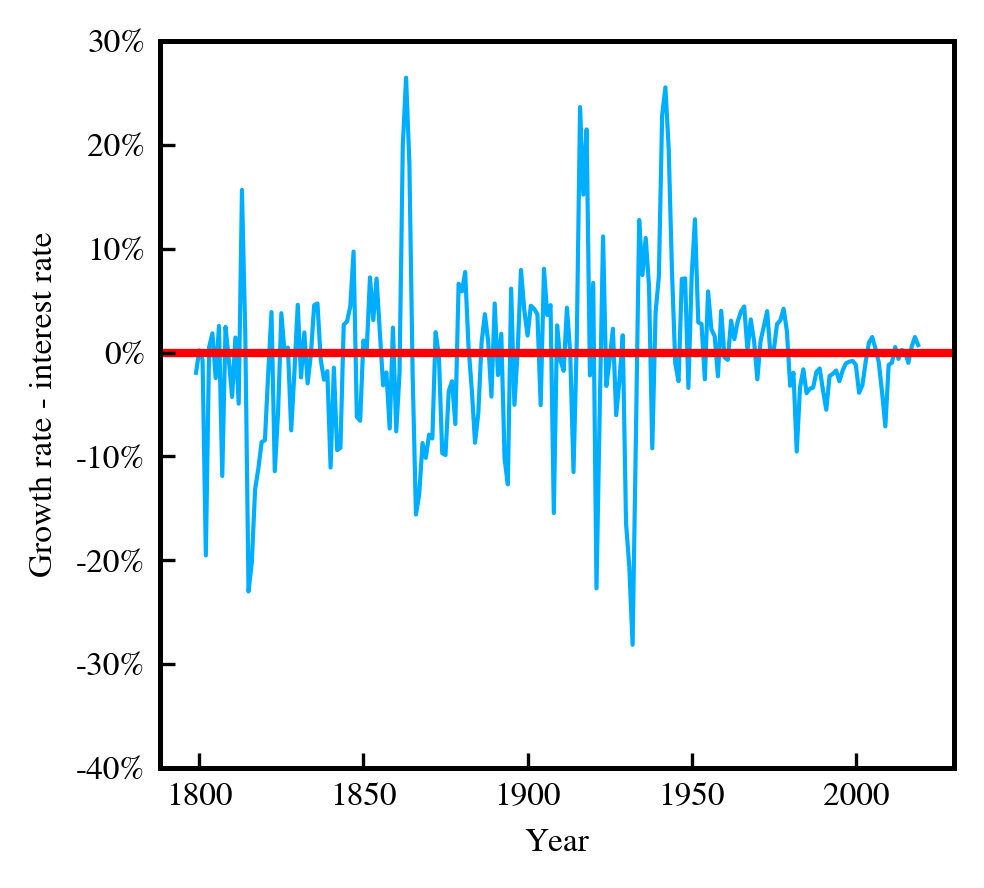

In [289]:
historical_GDP = pd.read_csv('US_historical_gdp.csv').set_index('Year')
historical_interest = pd.read_csv('US_interestrates_historical.csv').set_index('Year')
historical_GDP

historical_interest = historical_interest['US Long-Term Rate: Consistent Series']
historical_GDP = historical_GDP['Nominal GDP (million of Dollars)'].pct_change()*100

plt.figure()#figsize=(6.6,2.4))
plt.plot(historical_GDP - historical_interest,lw=1)
plt.axhline(0,color='red')

plt.yticks(plt.yticks()[0],labels=[str(int(w))+'%' for w in plt.yticks()[0]])
plt.ylabel('Growth rate - interest rate')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig('historical_growthmininterest.pdf',bbox_inches='tight')

<h3>Monte Carlo Simulations</h3>

In [8]:
future_NL_GDP.loc[2020:2030].Value.pct_change().mean()

0.017579592618392304

KeyboardInterrupt: 

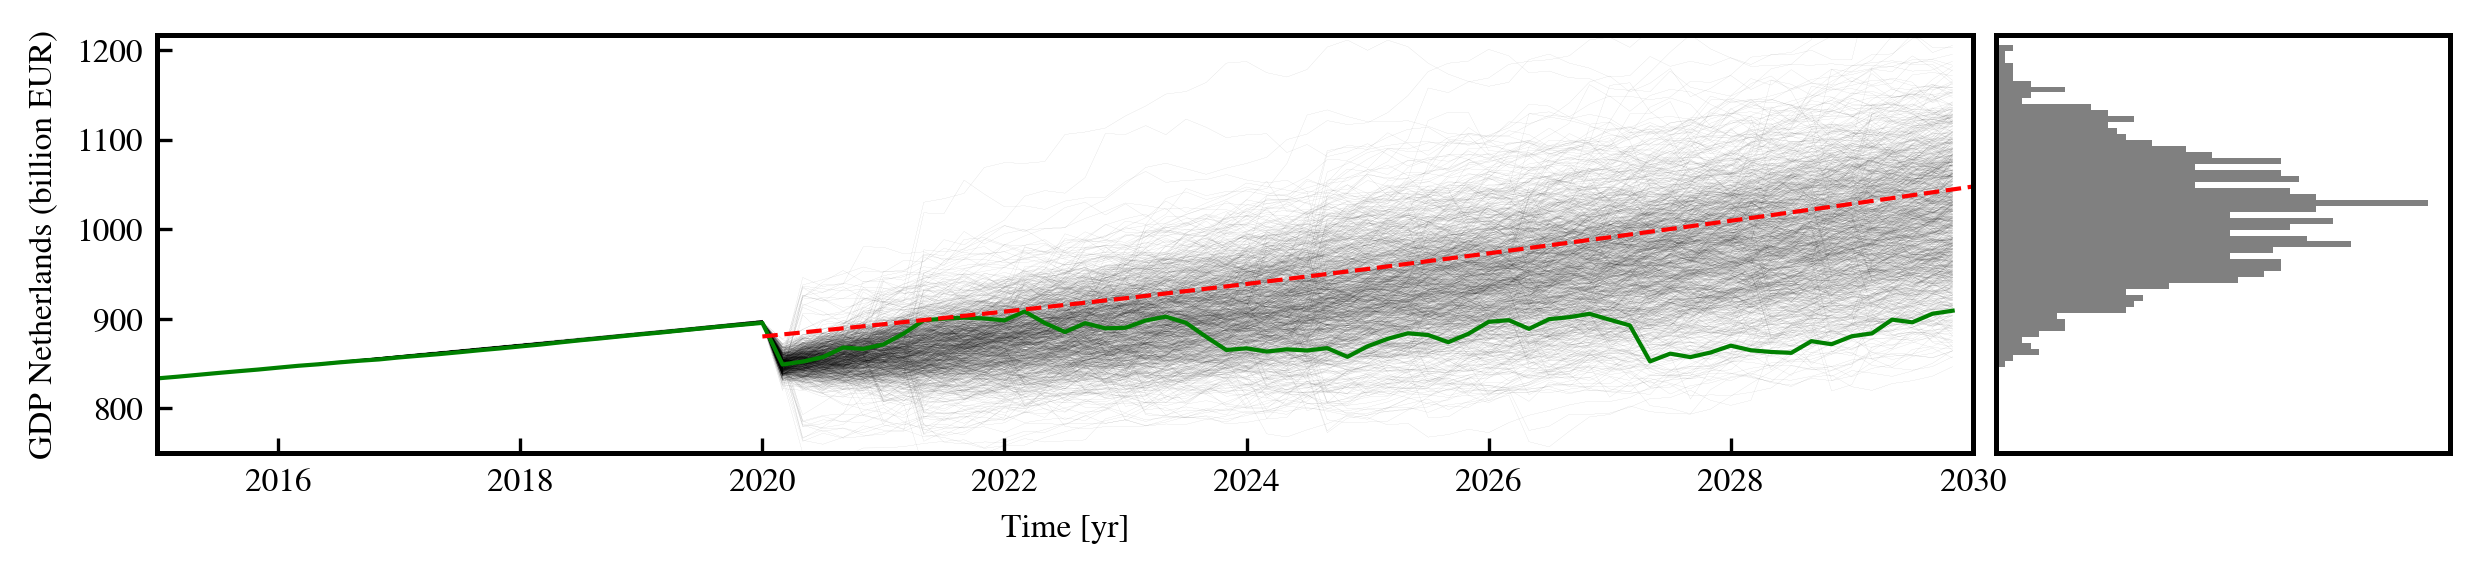

In [9]:
class MC_GDP():
    def __init__(self,sigma = 0.0226, mu = 0.011):
        self.mu =mu
        self.sigma = sigma
        self.x0    = future_NL_GDP.loc[2020,'Value']/(1+mu)**5
        np.random.seed(42)
        self.Npaths=1000
        self.Nsteps=90
        self.T=15
        self.dT = self.T/self.Nsteps
        self.prediction_interp = interp1d(future_NL_GDP.Value.index,future_NL_GDP.Value,kind='quadratic',fill_value='extrapolate')
        self.eta=np.log(2)/(6)
        
    def propagate(self,Sn,year):
        # We generate N(0,1) random variables
        # and multiply by sigma to get N(0,vola^2) variables
        
        phis = np.random.randn(len(Sn))
        shocks_per_year = 0.1
        posshock = np.random.poisson(size=len(Sn),lam=shocks_per_year*self.dT)
        negshock = np.random.poisson(size=len(Sn),lam=shocks_per_year*self.dT)
        shocksize = np.random.randn()*0.03+0.02
        mean = self.prediction_interp(year+2020)
        if year<5:
            sigma = 0.0005
            posshock=0
            negshock=0
        else:
            sigma = self.sigma
        if year==5:
            posshock=0
            negshock=3
        return Sn + Sn * (self.mu*self.dT + sigma*np.sqrt(self.dT)*phis-negshock*shocksize+posshock*shocksize)+0.01*np.exp(-self.eta*self.dT)*(mean-Sn)
            
    def payout(self,prices,T,M):
        # Payout is price - strike IF larger than zero. Thus take max(0,S-K)
        payoff = np.max(np.vstack(((prices - self.K),
                                    np.zeros(len(prices)))),axis=0)
        # Discount by rf rate
        return np.exp(-1*self.mu * T)* np.mean(payoff)
    
    def simulate(self,M,N,T):
        dT = T/N
        # Start all at S0
        prices = np.ones(M) * self.S0
        # Iterate through N steps by the Euler equation
        for i in range(N):
            prices = self.propagate(prices,dT)
        # Get payout from these prices
        payout = self.payout(prices,T,M)
        return payout
    
    def simulate_many(self):
        """Simulate Npaths for Nsteps"""
        xt = np.zeros((self.Npaths, self.Nsteps))
        # Same as before but now a whole matrix with N paths
        xt[:,0] = self.x0
        for i in range(self.Nsteps-1):
            xt[:,i+1] = self.propagate(xt[:,i],i*self.dT)
        prices = xt
        return prices
    
    def plot_many(self):
        """Make a plot of the overall distribution and also plot the resulting PDF of final 
           GDPs."""
        prices = self.simulate_many()
        prices = prices/1e3
        timearr = np.arange(2015,2030,self.dT)
        fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]},figsize=(8,1.7))
        for i in range(self.Npaths-1):
            a0.plot(timearr,prices[i,:],color='black',lw=0.01)
        a0.plot(timearr,prices[i,:],color='green',lw=1.0)
        
        limits = 0.9*np.min(prices[:,0]),1.1*np.percentile(prices[:,-1],q=90)
        
        a0.set_xlabel('Time [yr]')
        a0.set_ylabel('GDP Netherlands (billion EUR)')
        a0.set_xticks(a0.get_xticks()[:-1])
        a0.set_xlim(2015,2030)
        a0.set_ylim(limits)
        a0.plot(future_NL_GDP.index,future_NL_GDP.Value.values/1e3,color='red',ls='--',lw=1)
        
        a1.hist(prices[:,-1],bins=70, orientation="horizontal", color='gray')
        a1.set_xticks([])
        a1.set_yticks([])
        a1.set_ylim(limits)
        a0.set_rasterized(True)
        fig.tight_layout(pad=-0.3)
        plt.savefig('manyMCtracks_PDF.png', dpi=400,bbox_inches='tight')
        
        plt.show()
        return prices
# Exercise a
MC = MC_GDP()
future_GDPs = MC.plot_many()

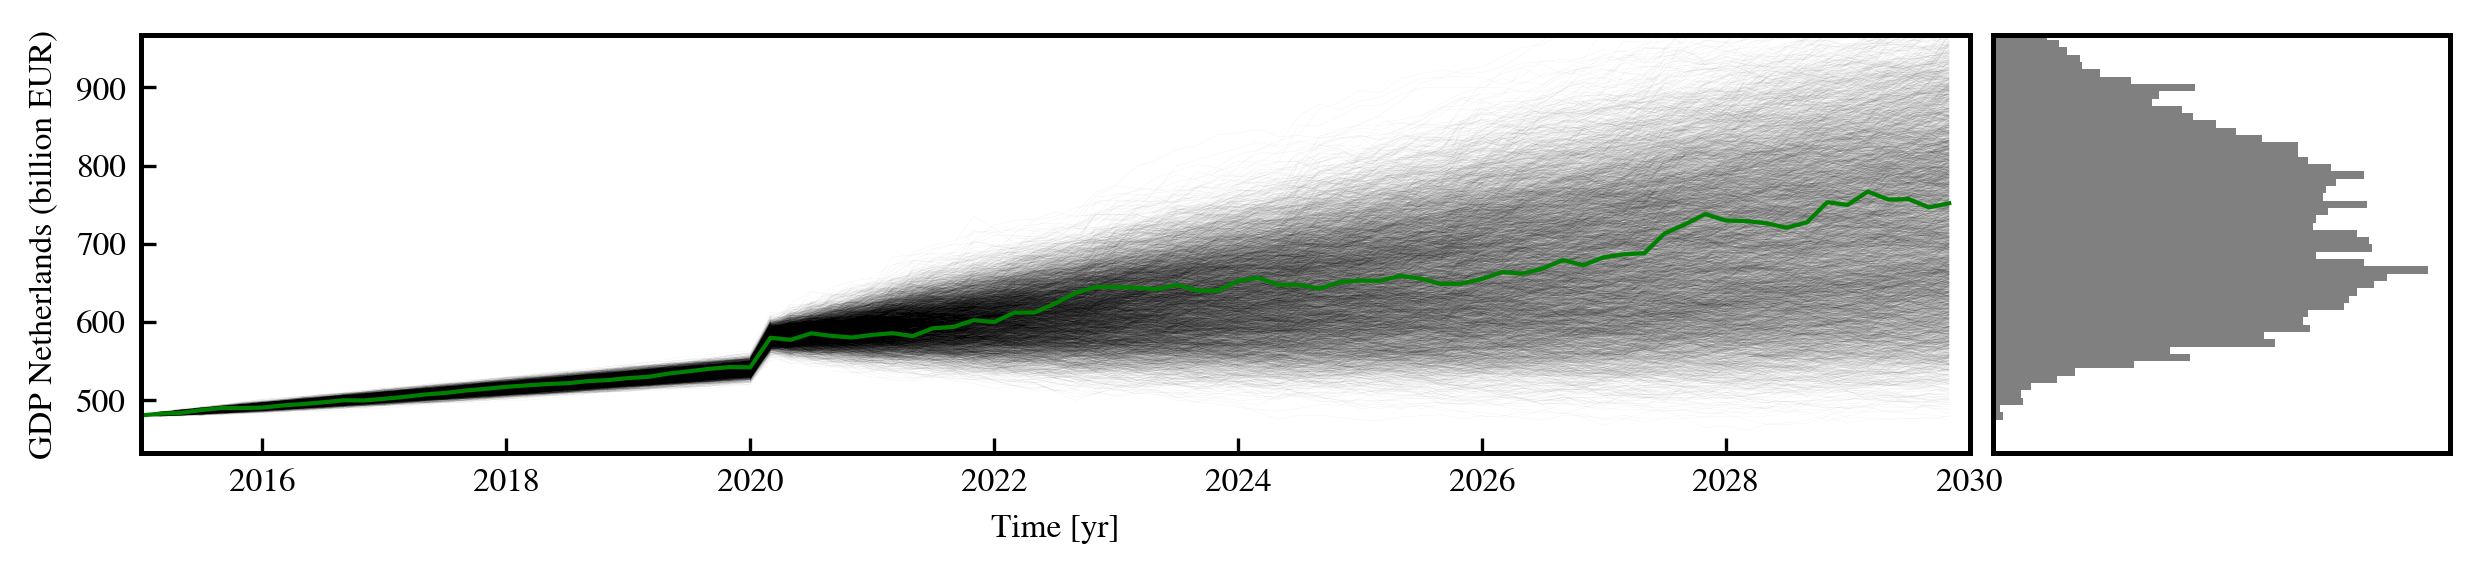

In [489]:
class MC_debt():
    def __init__(self,sigma = 0.0226, mu = 0.023480):
        self.mu =mu
        self.sigma = sigma
        self.x0    = 480000
        np.random.seed(42)
        self.Npaths=5000
        self.Nsteps=90
        self.T=15
        self.dT = self.T/self.Nsteps
        
    def propagate(self,Sn,year):
        # We generate N(0,1) random variables
        # and multiply by sigma to get N(0,vola^2) variables
        try:
            self.economy = np.sin(year/4 - self.phase)+0.5
        except: 
            # All economy at 0
            self.phase = np.random.randn(len(Sn))*np.pi
            self.economy = np.sin(year/4 - self.phase)+0.5
            
        phis = np.random.randn(len(Sn))
        shocks_per_year = 0.5
        
        if year<5:
            sigma = 0.005
            self.economy = 1
            posshock=0
            shocksize=0
        else:
            sigma = self.sigma
        if year==5:
            posshock = 1
            shocksize = np.random.randn()*0.01+0.06
        if year>5:
            posshock = np.random.poisson(size=len(Sn),lam=shocks_per_year*self.dT)
            shocksize = np.random.randn()*0.01+0.02
            
        return Sn + Sn * (self.economy*self.mu*self.dT + sigma*np.sqrt(self.dT)*phis+posshock*shocksize)+np.clip(15000*(self.x0/Sn-1),0,np.inf)
     
    def simulate_many(self):
        """Simulate Npaths for Nsteps"""
        xt = np.zeros((self.Npaths, self.Nsteps))
        # Same as before but now a whole matrix with N paths
        xt[:,0] = self.x0
        for i in range(self.Nsteps-1):
            xt[:,i+1] = self.propagate(xt[:,i],i*self.dT)
        prices = xt
        return prices
    
    def plot_many(self):
        """Make a plot of the overall distribution and also plot the resulting PDF of final 
           GDPs."""
        prices = self.simulate_many()
        prices = prices/1e3
        timearr = np.arange(2015,2030,self.dT)
        fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]},figsize=(8,1.7))
        for i in range(self.Npaths-1):
            a0.plot(timearr,prices[i,:],color='black',lw=0.005)
        a0.plot(timearr,prices[i,:],color='green',lw=1.0)
        
        limits = 0.9*np.min(prices[:,0]),1.1*np.percentile(prices[:,-1],q=90)
        
        a0.set_xlabel('Time [yr]')
        a0.set_ylabel('GDP Netherlands (billion EUR)')
        a0.set_xticks(a0.get_xticks()[:-1])
        a0.set_xlim(2015,2030)
        a0.set_ylim(limits)
        
        
        a1.hist(prices[:,-1],bins=70, orientation="horizontal", color='gray')
        a1.set_xticks([])
        a1.set_yticks([])
        a1.set_ylim(limits)
        a0.set_rasterized(True)
        fig.tight_layout(pad=-0.3)
        #plt.savefig('manyMCtracks_PDF.png', dpi=400,bbox_inches='tight')
        
        plt.show()
        return prices
# Exercise a
MC = MC_debt()
future_debt = MC.plot_many()

Text(0, 0.5, 'Debt/GDP (%)')

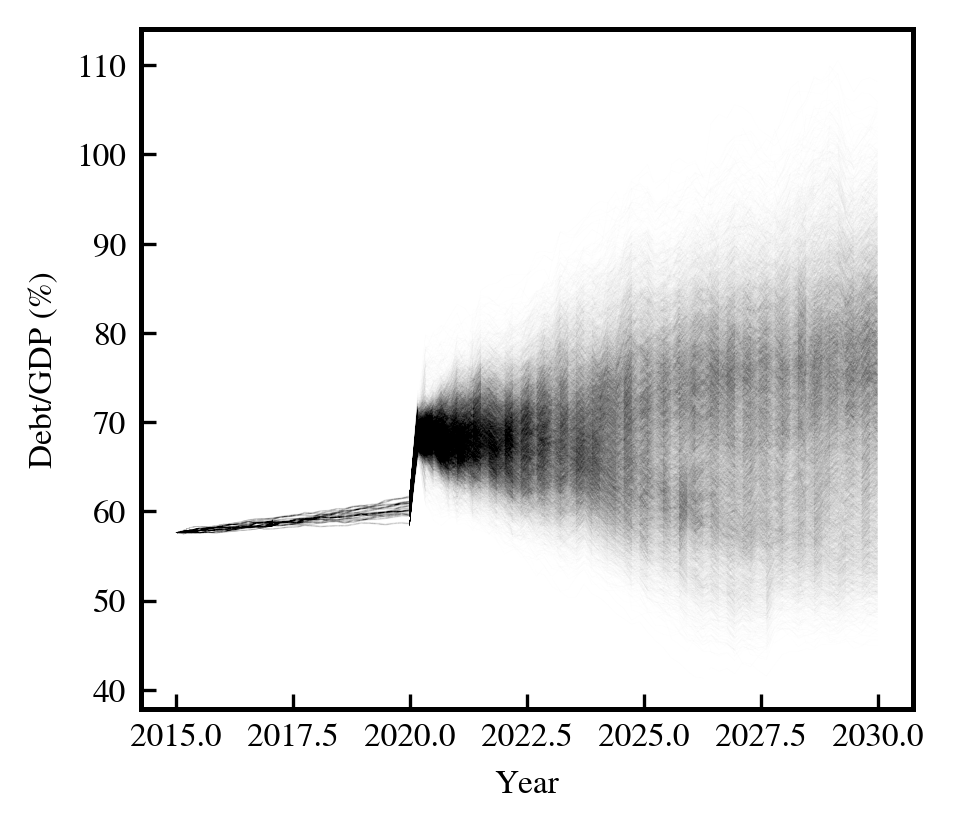

In [500]:
for i in future_debt[180:200,:]:
    relative_debt = i/future_GDPs[500:1000,:]
    for i in relative_debt:
        plt.plot(np.linspace(2015,2020,30),i[:30]*100,color='black',lw=0.0001)
        plt.plot(np.linspace(2020,2030,60),i[30:]*100,color='black',lw=0.001)
plt.xlabel('Year')
plt.ylabel('Debt/GDP (%)')

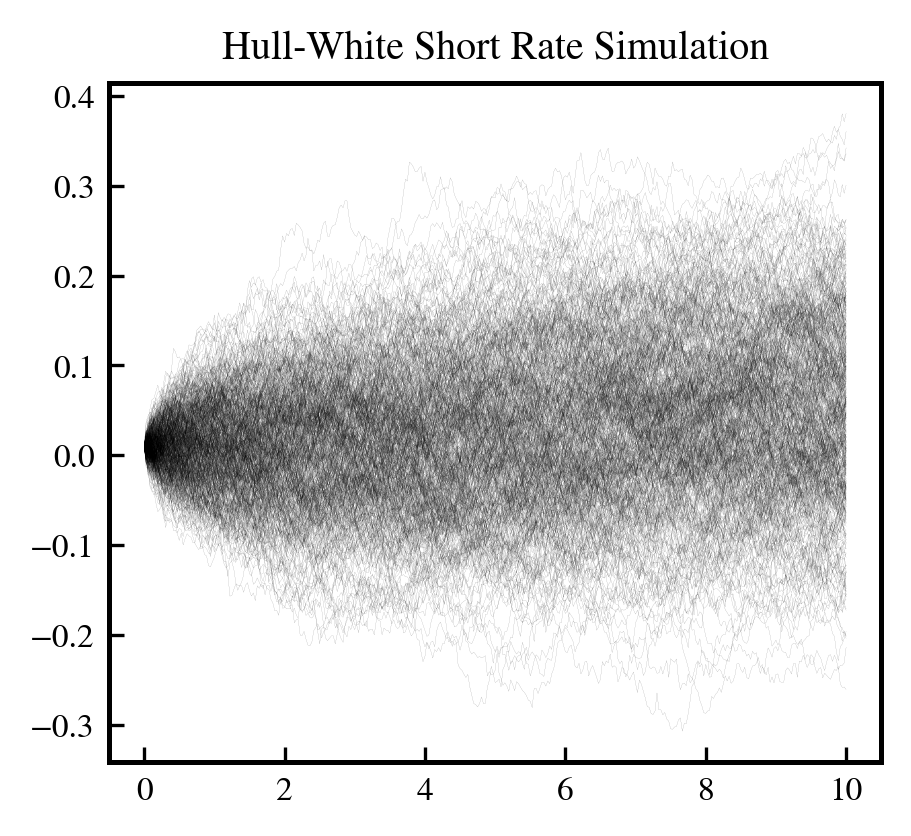

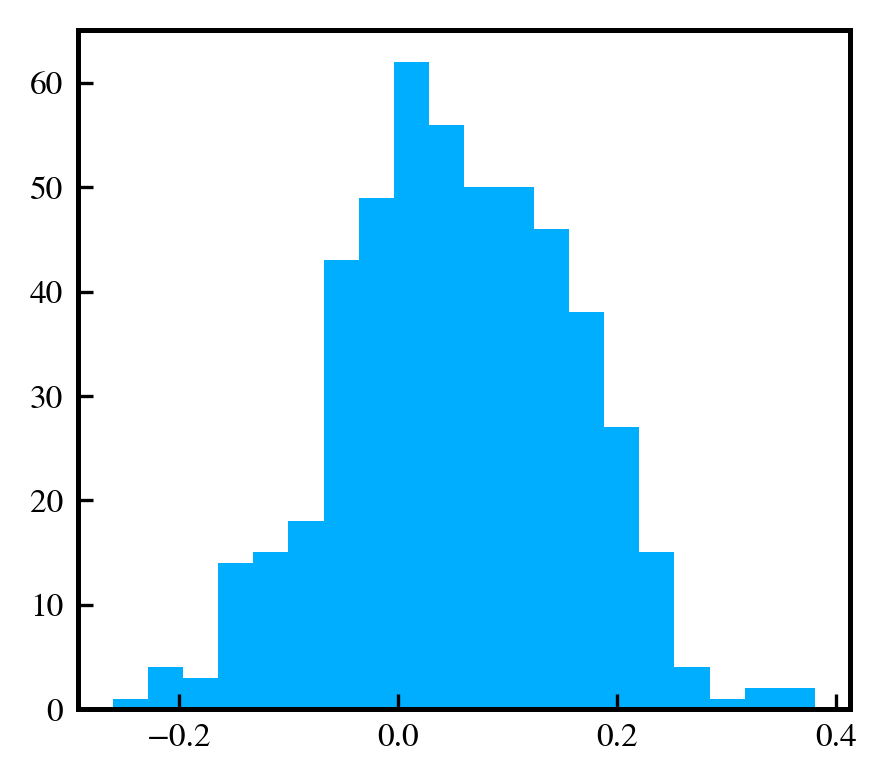

In [10]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np



sigma = 0.05
a = 0.1
timestep = 360
length = 10 # in years
forward_rate = 0.01
day_count = ql.Thirty360()
todays_date = ql.Date(15, 1, 2020)

ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

num_paths = 500
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.02, color='black')
plt.title("Hull-White Short Rate Simulation")
plt.show()

plt.hist(paths[:,-1],bins=20)
plt.show()

In [67]:
government_debt = pd.read_csv('./datafiles/government_debt.csv').set_index('Country')
government_debt = government_debt.replace({'no data':np.nan})
government_debt = government_debt.astype(float)
government_debt.columns = government_debt.columns.astype(float)
public_debt = pd.read_csv('./datafiles/public_debt.csv').set_index('Country')
public_debt = public_debt.replace({'no data':np.nan})
public_debt = public_debt.astype(float)
public_debt.columns = public_debt.columns.astype(float)
real_GDP_growth = pd.read_csv('./datafiles/real_GDP_growth.csv').set_index('Country')
real_GDP_growth = real_GDP_growth.replace({'no data':np.nan})
real_GDP_growth = real_GDP_growth.astype(float)
real_GDP_growth.columns = real_GDP_growth.columns.astype(float)
inflation_rate = pd.read_csv('./datafiles/inflation_rate.csv').set_index('Country')
inflation_rate = inflation_rate.replace({'no data':np.nan})
inflation_rate = inflation_rate.astype(float)
inflation_rate.columns = inflation_rate.columns.astype(float)

gross_debt_outlook = pd.read_csv('./datafiles/gros_debt_outlook.csv').set_index('Country')
gross_debt_outlook = gross_debt_outlook.replace({'no data':np.nan})
gross_debt_outlook = gross_debt_outlook.astype(float)
gross_debt_outlook.columns = gross_debt_outlook.columns.astype(float)

net_debt_outlook = pd.read_csv('./datafiles/net_debt_outlook.csv').set_index('Country')
net_debt_outlook = net_debt_outlook.replace({'no data':np.nan})
net_debt_outlook = net_debt_outlook.astype(float)
net_debt_outlook.columns = net_debt_outlook.columns.astype(float)

In [64]:
net_debt_outlook.loc['Netherlands']

1990.0          NaN
1991.0          NaN
1992.0          NaN
1993.0          NaN
1994.0          NaN
1995.0    54.959687
1996.0    54.072398
1997.0    50.800984
1998.0    48.031550
1999.0    44.732143
2000.0    38.966211
2001.0    37.493697
2002.0    37.740179
2003.0    39.417133
2004.0    40.228534
2005.0    38.572256
2006.0    36.098100
2007.0    33.289888
2008.0    38.474779
2009.0    41.063021
2010.0    45.854656
2011.0    48.546572
2012.0    52.087551
2013.0    53.696119
2014.0    54.821312
2015.0    52.798808
2016.0    51.051406
2017.0    46.179753
2018.0    42.510713
2019.0    41.657434
2020.0    48.132147
2021.0    49.609568
2022.0    49.504682
2023.0    48.776139
2024.0    47.545770
2025.0    45.756584
Name: Netherlands, dtype: float64

In [8]:
country_type = pd.read_csv('./datafiles/countries_classification.csv')
country_classification = pd.DataFrame({'Country':[],'Type':[]})
i=0
types = {'Advanced Economies':'Advanced Economies','Emerging\nMarket and Middle-Income Economies\n':'Emerging markets','Low-Income Developing\nCountries\n':'Low income'}
for col in ['Advanced Economies','Emerging\nMarket and Middle-Income Economies\n','Low-Income Developing\nCountries\n']:
    for item in country_type[col].dropna().values:
        country_classification = country_classification.append({'Country':item,'Type':types[col]},ignore_index=True)

In [25]:
country_classification = country_classification.set_index('Type')

In [26]:
inflation = inflation_rate.iloc[:,35:40].agg(['median','std'],axis=1)
gov_debt  = government_debt.iloc[:,64:70].agg(['median','std'],axis=1)
GDP_growth = real_GDP_growth.iloc[:,35:40].agg(['median','std'],axis=1)

In [27]:
merged = pd.merge(inflation,gov_debt,left_index=True,right_index=True)
merged = pd.merge(merged,GDP_growth,left_index=True,right_index=True)
merged.columns = ['median_infl','std_infl','median_govdebt','std_govdebt','median_growth','std_growth']


In [29]:
(1+real_GDP_growth/100).product(axis=1)

Country
Afghanistan                      3.399658
Albania                          3.202328
Algeria                          2.826870
Angola                           8.556028
Antigua and Barbuda              4.618056
                                   ...   
Major advanced economies (G7)    2.514464
Middle East and Central Asia     4.147514
Other advanced economies         5.096995
Sub-Saharan Africa               3.726516
World                            4.534894
Length: 227, dtype: float64

Text(0, 0.5, 'Average GDP Growth (2015-2019)')

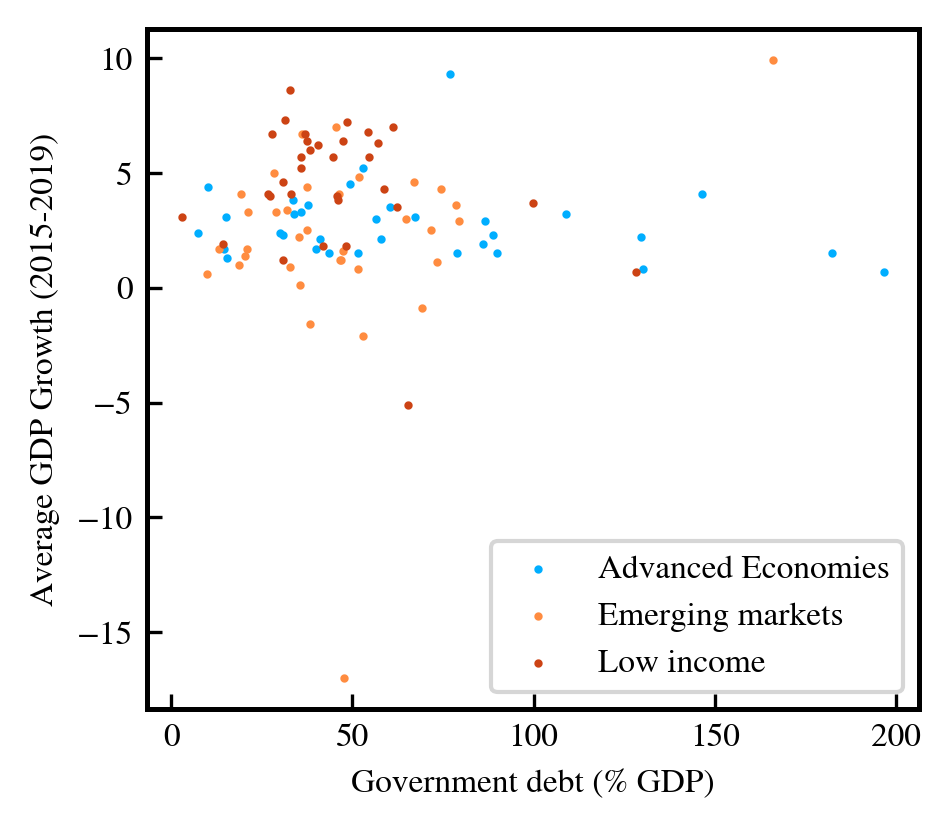

In [32]:
for type_ in country_classification.index.unique():
    countries = country_classification.loc[type_].values.flatten()
    df = merged.reindex(countries)
    #, xerr=df.std_govdebt,yerr=df.std_growth,ls='none'
    plt.scatter(x=df.median_govdebt,y=df.median_growth,s=1,label=type_)
plt.legend(frameon=1)
plt.xlabel('Government debt (% GDP)')
plt.ylabel('Average GDP Growth (2015-2019)')

Text(0, 0.5, 'Average inflation (2015-2019)')

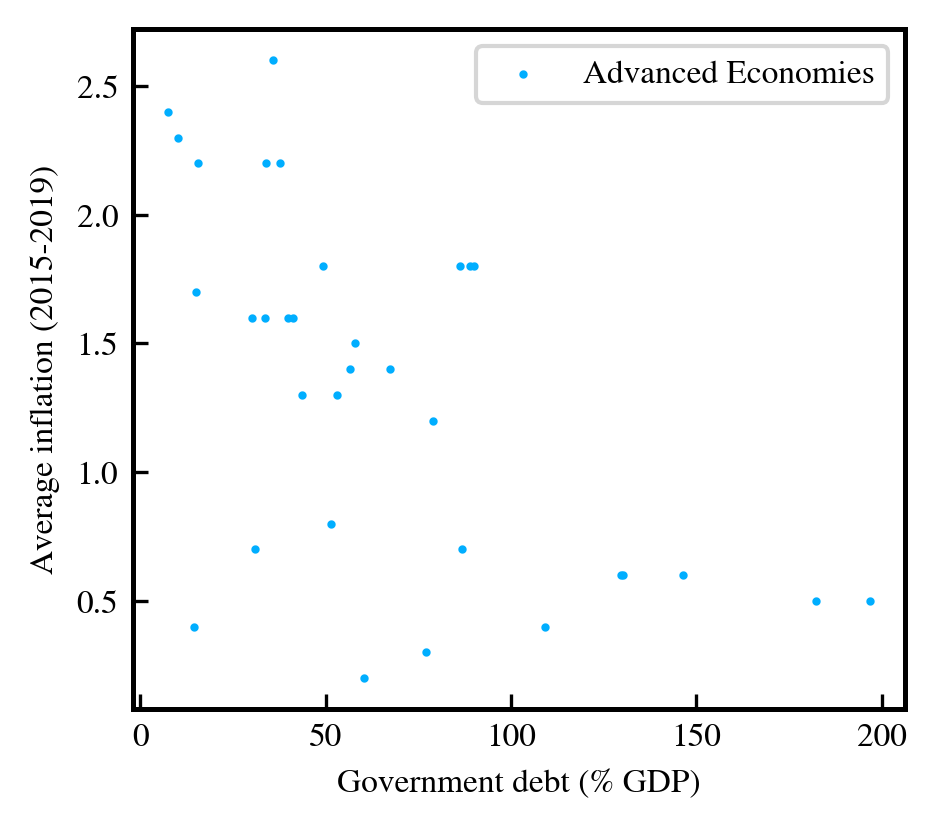

In [23]:
for type_ in country_classification.index.unique()[:1]:
    countries = country_classification.loc[type_].values.flatten()
    df = merged.reindex(countries)
    df = df[df.std_infl<100]
    #, xerr=df.std_govdebt,yerr=df.std_infl,ls='none',lw=1
    plt.scatter(x=df.median_govdebt,y=df.median_infl,label=type_,s=1)
plt.legend(frameon=1)
plt.xlabel('Government debt (% GDP)')
plt.ylabel('Average inflation (2015-2019)')

In [25]:
gross_debt_outlook.index[-15:]

Index(['Advanced G-20', 'Advanced economies', 'Emerging G-20',
       'Emerging Market and Middle-Income Economies',
       'Emerging and Middle-Income Asia', 'Emerging and Middle-Income Europe',
       'Emerging and Middle-Income Latin America',
       'Emerging and Middle-Income Middle East and North Africa and Pakistan',
       'Euro area', 'Low-Income Developing Asia',
       'Low-Income Developing Countries',
       'Low-Income Developing Latin America',
       'Low-Income Developing Oil Producers', 'Low-Income Developing Others',
       'Low-Income Developing Sub-Saharan Africa'],
      dtype='object', name='Country')

In [26]:
advanced_economies = pd.read_csv('./datafiles/imf_debts_advanced.txt',delimiter=', ',skiprows=1,header=None)
emerging_economies = pd.read_csv('./datafiles/imf_debts_emerging.txt',delimiter=', ',skiprows=1,header=None)

<ipython-input-26-801155026211>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  advanced_economies = pd.read_csv('./datafiles/imf_debts_advanced.txt',delimiter=', ',skiprows=1,header=None)
<ipython-input-26-801155026211>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  emerging_economies = pd.read_csv('./datafiles/imf_debts_emerging.txt',delimiter=', ',skiprows=1,header=None)


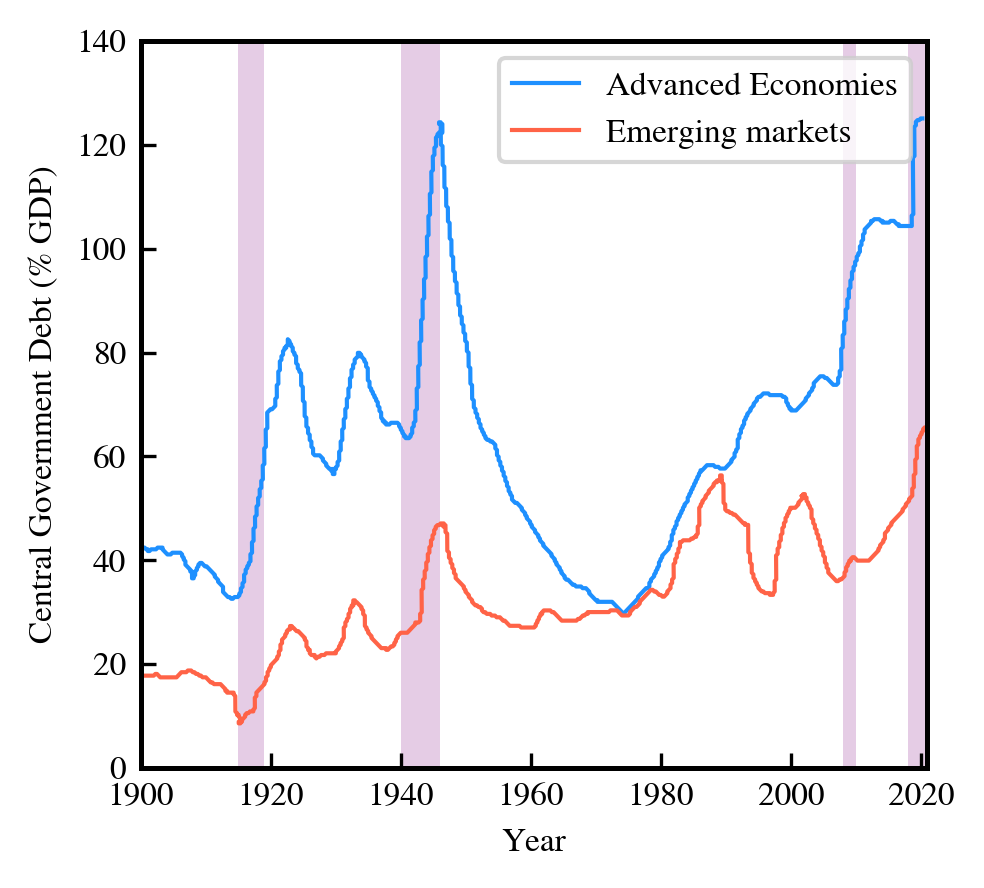

In [27]:
fig,ax = plt.subplots()
ax.plot(advanced_economies.iloc[:,0],advanced_economies.iloc[:,1],lw=1,color='dodgerblue',label='Advanced Economies')
ax.plot(emerging_economies.iloc[:,0],emerging_economies.iloc[:,1],lw=1,color='tomato',label='Emerging markets')
ax.set_xlim(1900,2021)
ax.set_xlabel('Year')
ax.set_ylabel('Central Government Debt (% GDP)')
rect1 = patches.Rectangle((2008,-10),2,200,linewidth=1,edgecolor='none',facecolor='purple',alpha=0.2)
rect2 = patches.Rectangle((2018,-10),3,200,linewidth=1,edgecolor='none',facecolor='purple',alpha=0.2)
rect3 = patches.Rectangle((1940,-10),6,200,linewidth=1,edgecolor='none',facecolor='purple',alpha=0.2)
rect4 = patches.Rectangle((1915,-10),4,200,linewidth=1,edgecolor='none',facecolor='purple',alpha=0.2)
ax.set_ylim(0,140)
# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
plt.legend(frameon=1)
plt.tight_layout()
plt.savefig('IMF_debt.pdf')

In [55]:
country_classification.index.unique()

Index(['Advanced Economies', 'Emerging markets', 'Low income'], dtype='object', name='Type')

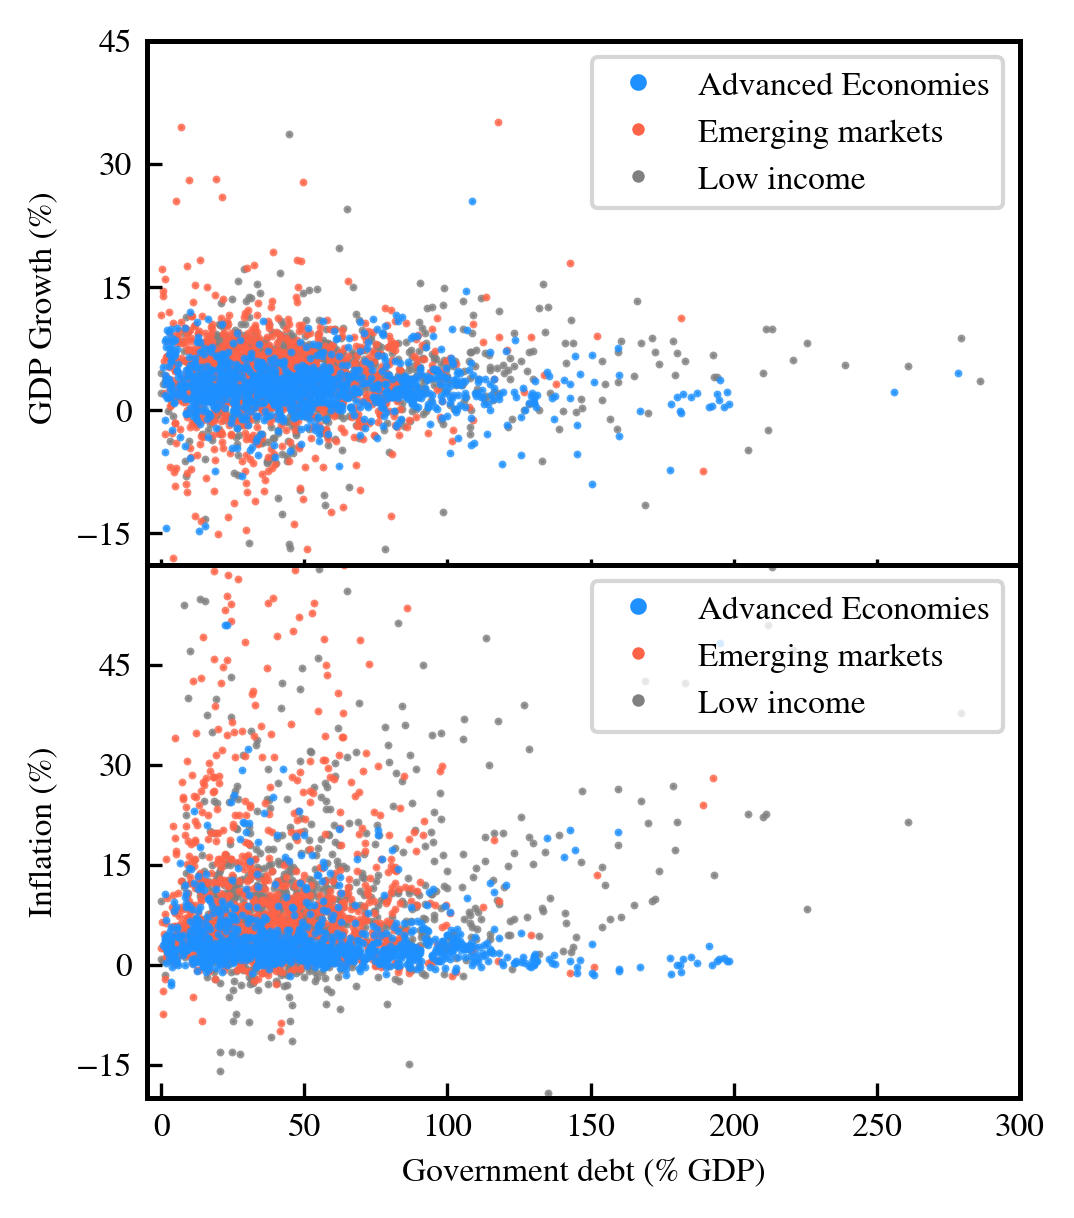

In [133]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(3.321,3.8))
for type_ in country_classification.index.unique()[::-1]:
    countries = country_classification.loc[type_].values.flatten()
    colors = {'Advanced Economies':'dodgerblue','Emerging markets':'tomato','Low income':'grey'}
    for year in np.arange(1980,2020,1):
        try:
            debt = government_debt.reindex(countries)[year]
            growth = real_GDP_growth.reindex(countries)[year+1]
            inflation = inflation_rate.reindex(countries)[year+1]
            ax1.scatter(debt,growth,s=0.8,color=colors[type_],label=type_,alpha=0.8)
            ax2.scatter(debt,inflation,s=0.8,color=colors[type_],label=type_,alpha=0.8)
            
        except:
            continue
    
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Advanced Economies',
                          markerfacecolor='dodgerblue', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Emerging markets',
                          markerfacecolor='tomato', markersize=4),
                   Line2D([0], [0], marker='o', color='w', label='Low income',
                          markerfacecolor='grey', markersize=4)]

# Create the figure
ax1.legend(handles=legend_elements,frameon=1)
ax2.legend(handles=legend_elements,frameon=1)

ax1.set_ylim(-20,40)
ax1.set_xticklabels(['']*len(ax1.get_xticks()))
ax2.set_ylim(-20,60)
ax1.set_xlim(-5,300)
ax2.set_xlim(-5,300)
ax2.set_yticks([-15,0,15,30,45])
ax1.set_yticks([-15,0,15,30,45])
plt.xlabel('Government debt (% GDP)')
ax1.set_ylabel('GDP Growth (%)')
ax2.set_ylabel('Inflation (%)')
plt.tight_layout(pad=-0.28)
plt.savefig('Debt_vs_inflation_GDP.pdf',bbox_inches='tight')

In [278]:
govdeb = government_debt.iloc[:,40:].dropna()
gdpgr  = real_GDP_growth.iloc[:,10:].dropna()
infr   = inflation_rate.iloc[:,10:].dropna()

In [279]:
paneldata = pd.DataFrame({'Debt':govdeb.stack(),'GDPgrowth':gdpgr.stack(),'Inflation':infr.stack()}).dropna()

In [280]:
# imports the permutation function to generate all permutations of 2 of the FANG stocks
from itertools import permutations
# imports test for Granger Causality (does variable x have value in predicting y)
from statsmodels.tsa.stattools import grangercausalitytests

In [284]:
def find_granger_causality(land):
    df = paneldata
    variables = df.columns
    data = df.loc[land]
    # creates a list of tuples containing the permutations of length 2 of the FANG stocks
    var_perms = list(permutations(variables, 2))
    granger_df = pd.DataFrame(index=variables, columns=variables)
    granger_df_sign = pd.DataFrame(index=variables, columns=variables)
    # loops through the list of stock permutations
    for i in range(len(var_perms)):
        # converts the tuple to a list so it can be passed to the dataframe for column selection
        temp_list = list(var_perms[i])
        # creates a temporary dataframe of just the two variables
        temp_df = data[temp_list].dropna()
        # prints which permutation is being tested for interpretability
        #print('Does a lag of ' + temp_list[1] + ' predict ' + temp_list[0])
        # prints the results of a Granger Causality test for each permutation with 1 lage
        granger_output = grangercausalitytests(temp_df, maxlag = 1, addconst = True, verbose = False)
        beta_OLS = granger_output[1][1][0].params[0]
        # leaves two spaces for readability
        granger_df.loc[temp_list[0],temp_list[1]] = granger_output[1][0]['ssr_chi2test'][1]
        granger_df_sign.loc[temp_list[0],temp_list[1]] = beta_OLS / np.abs(beta_OLS)
    granger = (granger_df<0.05).stack()
    granger_df_sign = granger_df_sign.stack()[granger].dropna()
    granger = granger[granger].dropna()
    granger[granger] = land
    return granger, granger_df_sign


def combine_granger():
    countries = paneldata.index.get_level_values(0).unique()
    granger_dfs = [find_granger_causality(w)[0] for w in countries]
    granger_dfs_beta = [find_granger_causality(w)[1] for w in countries]
    a = pd.DataFrame(pd.concat(granger_dfs).sort_index()).reset_index()
    #b = pd.DataFrame(pd.concat(granger_dfs_beta).sort_index()).reset_index()
    a.columns=['col1','col2','country']
    #b.columns=['col1','col2','beta_OLS']
    a=a.set_index(['col1','col2'])
    #b=b.set_index(['col1','col2'])
    
    a = pd.get_dummies(a).groupby(['col1','col2']).sum()
    #a['NL'] = 0
    #a.columns = ['NO','SA','TH','NL']
    #a=a[['NL','NO','SA','TH']]
    #return a
    return a
a=combine_granger()


In [285]:
results = pd.DataFrame({'TypeOfCountry':[],'FractionGDP':[],'FractionInfl':[]}).set_index('TypeOfCountry')
for type_ in country_classification.index.unique():
    countries = country_classification.loc[type_].values.flatten()
    results_D_G = 0
    N = 0
    results_D_I = 0
    for country in countries:
        try:
            results_D_G += a['country_'+country].loc['Debt','GDPgrowth']
            results_D_I += a['country_'+country].loc['Debt','Inflation']
            N += 1
        except:
            continue
    results.loc[type_] = [results_D_G/N,results_D_I/N]
    print(N)

23
19
11


In [288]:
a.mean(axis=1)

col1       col2     
Debt       GDPgrowth    0.4250
           Inflation    0.3750
GDPgrowth  Debt         0.2250
           Inflation    0.3500
Inflation  Debt         0.2750
           GDPgrowth    0.2375
dtype: float64

<h3>VECM</h3>

In [15]:
from statsmodels.tsa.vector_ar.vecm import *

In [220]:
nl_govdebt = gross_debt_outlook.loc['Germany',:2020]

In [221]:
nl_gdp_growth = real_GDP_growth.loc['Germany',:2020]

In [222]:
nl_inflation = inflation_rate.loc['Netherlands',:2020]

In [226]:
data = pd.merge(nl_govdebt,nl_gdp_growth,left_index=True,right_index=True)
data = pd.merge(data,nl_inflation,left_index=True,right_index=True)
data.columns = ['Debt','GDP','Inflation']
data = data.dropna()
data=data[['Debt','GDP']]

In [227]:
lag_order = select_order(data=data, maxlags=15, deterministic="ct", seasons=0)
lag_order.summary()


/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/luuk/anaconda3/lib/pyt

<class 'statsmodels.iolib.table.SimpleTable'>

In [228]:
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic


(8, 7, 12, 8)

In [232]:
rank_test = select_coint_rank(data, 0, 3, method="trace",
                              signif=0.1)
rank_test.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [233]:
print(rank_test)

Johansen cointegration test using trace test statistic with 10% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          15.45          13.43
  1   2          4.603          2.705
-------------------------------------


In [234]:
rank_test.rank

2

In [235]:
model = VECM(data, deterministic="ct", seasons=0,
             k_ar_diff=lag_order.aic,  
             coint_rank=rank_test.rank)

vecm_res = model.fit()
vecm_res.summary()

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation Debt
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.Debt        1.2299      0.463      2.659      0.008       0.323       2.137
L1.GDP        -7.8040      1.884     -4.142      0.000     -11.497      -4.111
L2.Debt       -0.7162      0.604     -1.186      0.236      -1.900       0.468
L2.GDP        -4.9120      1.667     -2.947      0.003      -8.179      -1.645
L3.Debt       -0.7437      0.646     -1.151      0.250      -2.010       0.523
L3.GDP        -4.4489      1.686     -2.638      0.008      -7.754      -1.144
L4.Debt        1.6351      0.613      2.670      0.008       0.435       2.836
L4.GDP        -1.0466      1.371     -0.763      0.445      -3.733       1.640
L5.Debt        0.1915      0.396      0.484      0.628      -0.584       0.967
L5.GDP         2.5846      0.986      2.621      0.009       0.652       4.518
L6.Debt       -0.8710      0.273     -3.193      0.001      -1.406      -0.336
L6.GDP         3.4327      1.023      3.356      0.001       1.428       5.437
L7.Debt       -1.4244      0.303     -4.703      0.000      -2.018      -0.831
L7.GDP         3.1674      0.885      3.581      0.000       1.434       4.901
L8.Debt       -0.8239      0.387     -2.128      0.033      -1.583      -0.065
L8.GDP         1.0823      0.576      1.880      0.060      -0.046       2.211
Det. terms outside the coint. relation & lagged endog. parameters for equation GDP
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.Debt       -0.4084      0.171     -2.383      0.017      -0.744      -0.072
L1.GDP         5.4684      0.698      7.834      0.000       4.100       6.836
L2.Debt        0.6185      0.224      2.764      0.006       0.180       1.057
L2.GDP         3.8268      0.617      6.197      0.000       2.617       5.037
L3.Debt        0.7035      0.239      2.940      0.003       0.234       1.173
L3.GDP         3.2911      0.625      5.268      0.000       2.067       4.515
L4.Debt       -1.9494      0.227     -8.592      0.000      -2.394      -1.505
L4.GDP         0.9519      0.508      1.874      0.061      -0.043       1.947
L5.Debt        0.0401      0.147      0.274      0.784      -0.247       0.327
L5.GDP        -2.5230      0.365     -6.905      0.000      -3.239      -1.807
L6.Debt        0.7688      0.101      7.609      0.000       0.571       0.967
L6.GDP        -2.5446      0.379     -6.716      0.000      -3.287      -1.802
L7.Debt        0.9023      0.112      8.042      0.000       0.682       1.122
L7.GDP        -2.5709      0.328     -7.845      0.000      -3.213      -1.929
L8.Debt        0.5581      0.143      3.892      0.000       0.277       0.839
L8.GDP        -0.9767      0.213     -4.580      0.000      -1.395      -0.559
                Loading coefficients (alpha) for equation Debt                
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1           -0.1046      0.034     -3.044      0.002      -0.172      -0.037
ec2            8.7101      2.120      4.108      0.000       4.555      12.865
                Loading coefficients (alpha) for equation GDP                 
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [236]:
vecm_res.alpha


array([[-0.10464941,  8.71012516],
       [ 0.10702048, -7.63049677]])

In [237]:
vecm_res.stderr_alpha


array([[0.03438294, 2.12011333],
       [0.01273711, 0.7853929 ]])

In [238]:
vecm_res.predict(steps=5)


array([[101.59494036,  -7.63553914],
       [107.59100475,  15.71394103],
       [ 72.16802356,  28.3369397 ],
       [ 72.72769057, -26.94267323],
       [155.14421226, -50.45149007]])

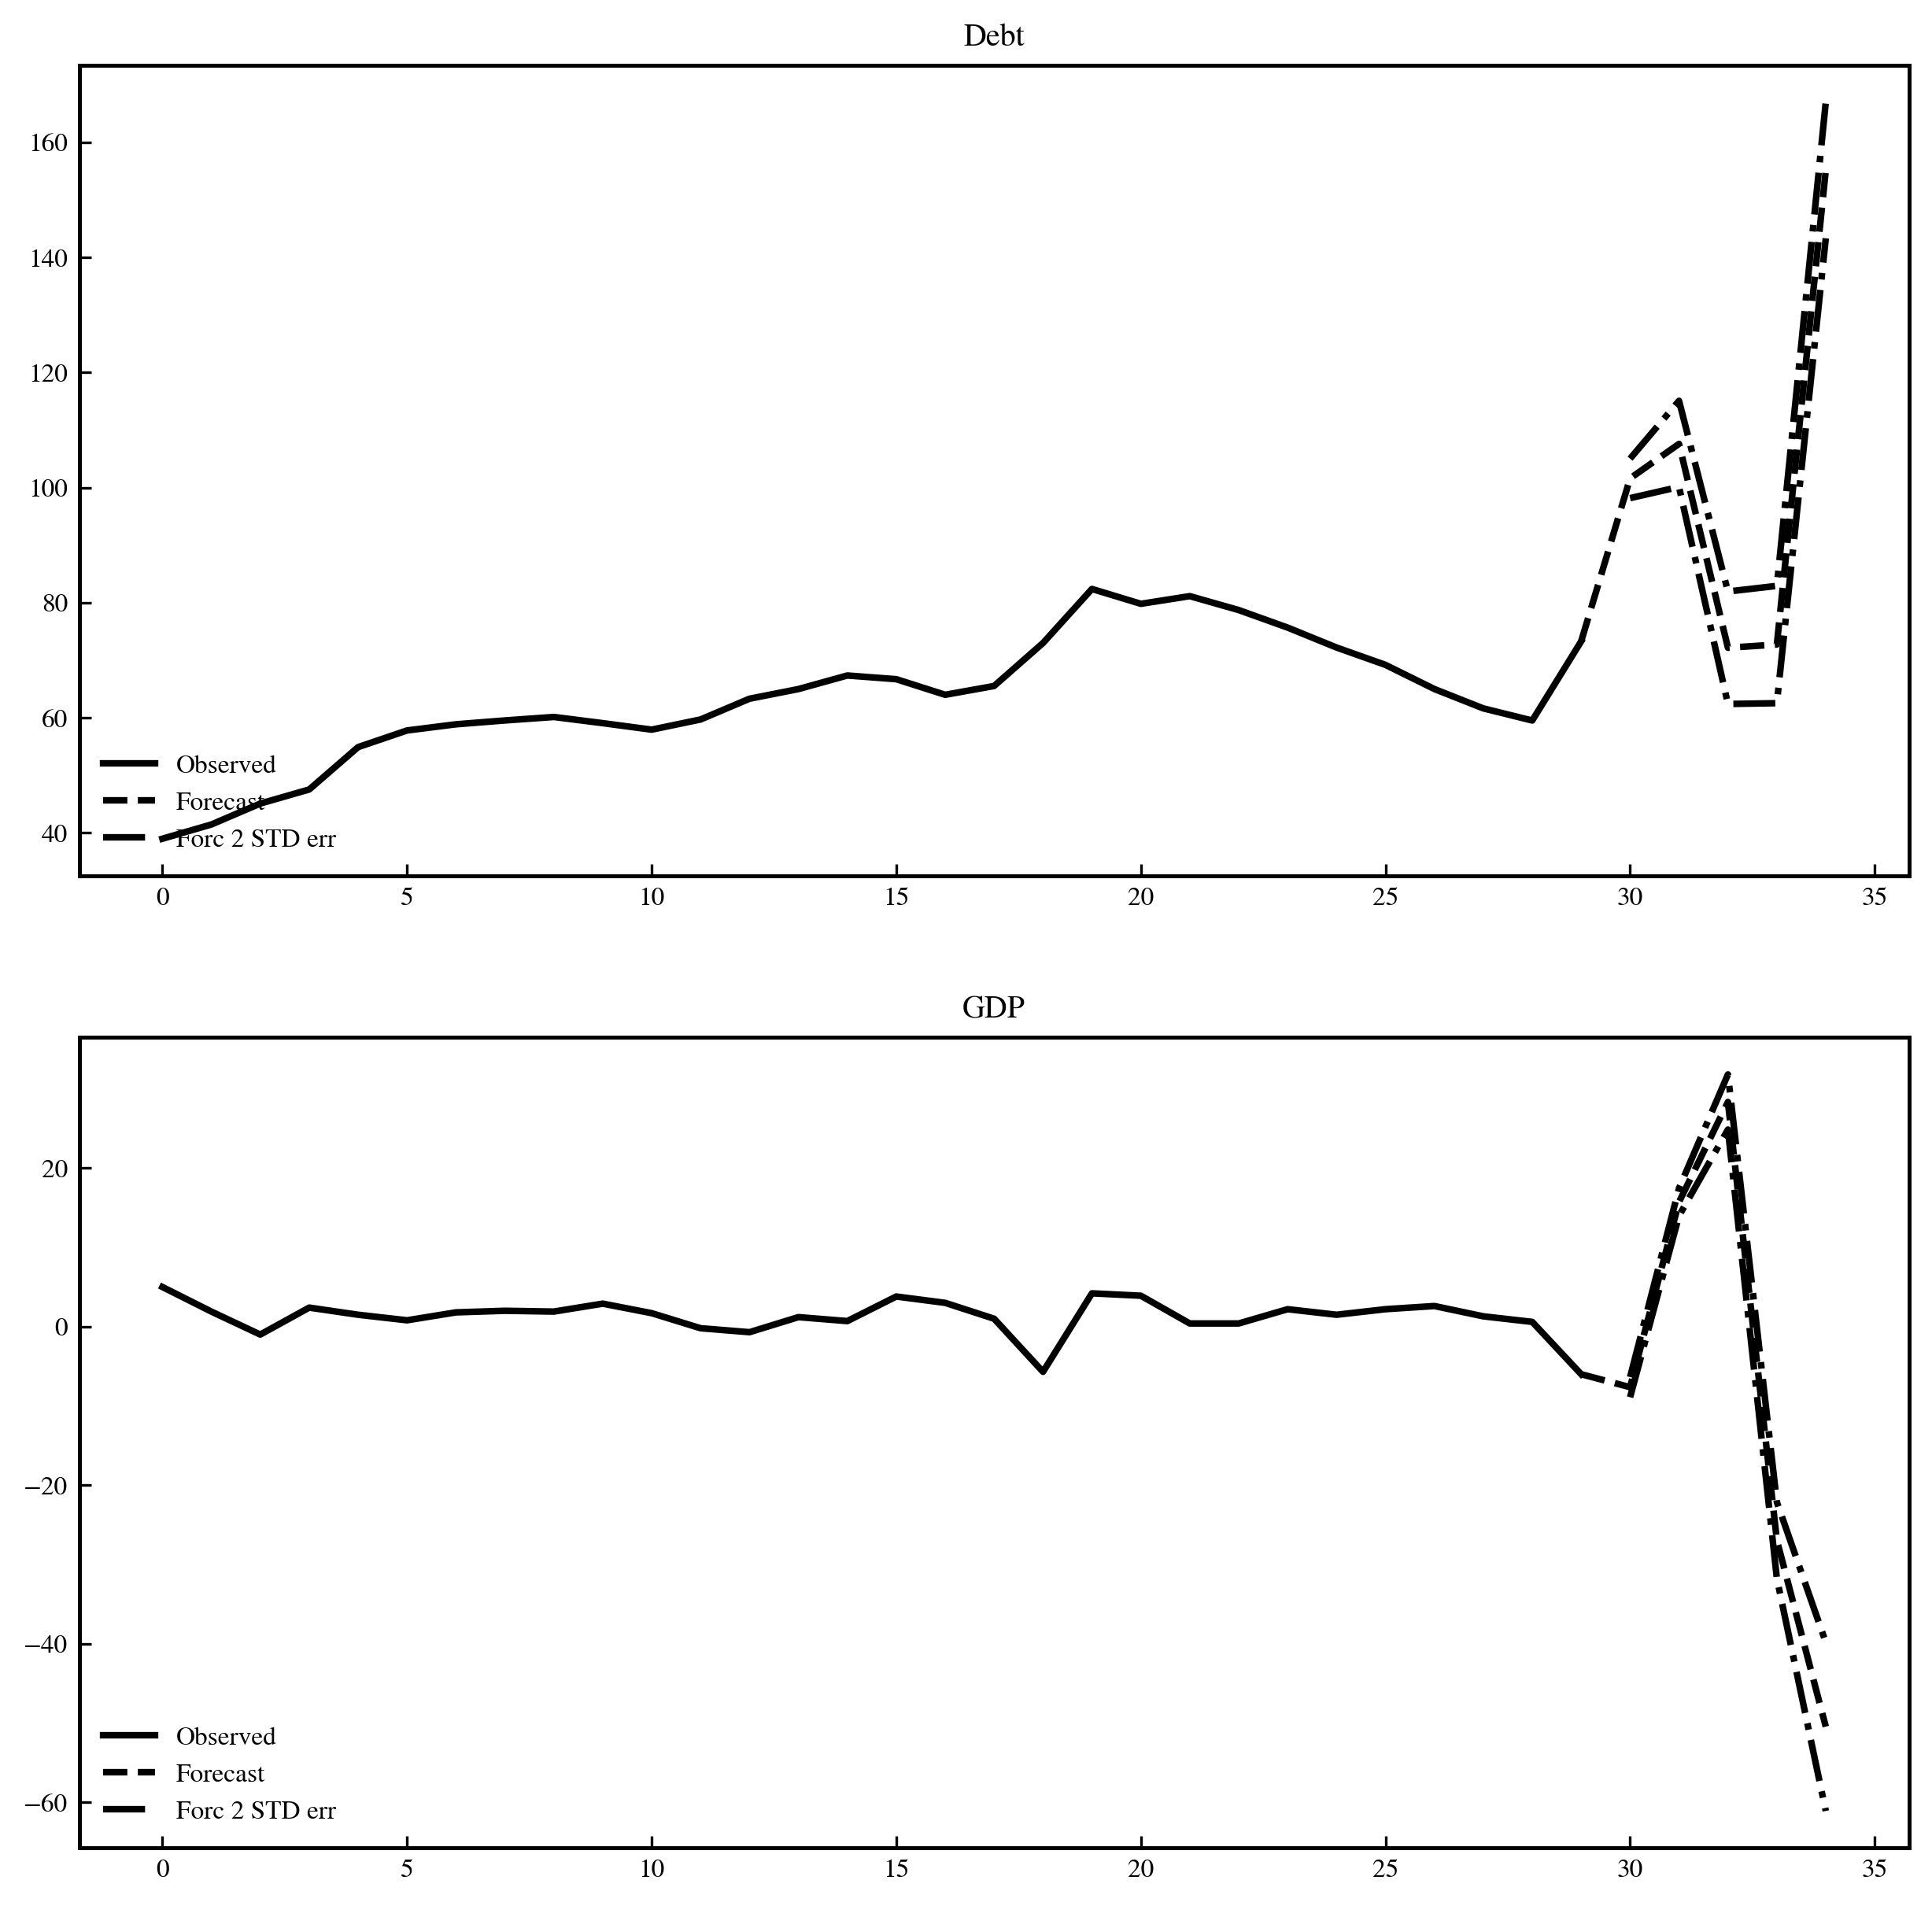

In [239]:
vecm_res.plot_forecast(steps=5, plot_conf_int=True,n_last_obs=30)

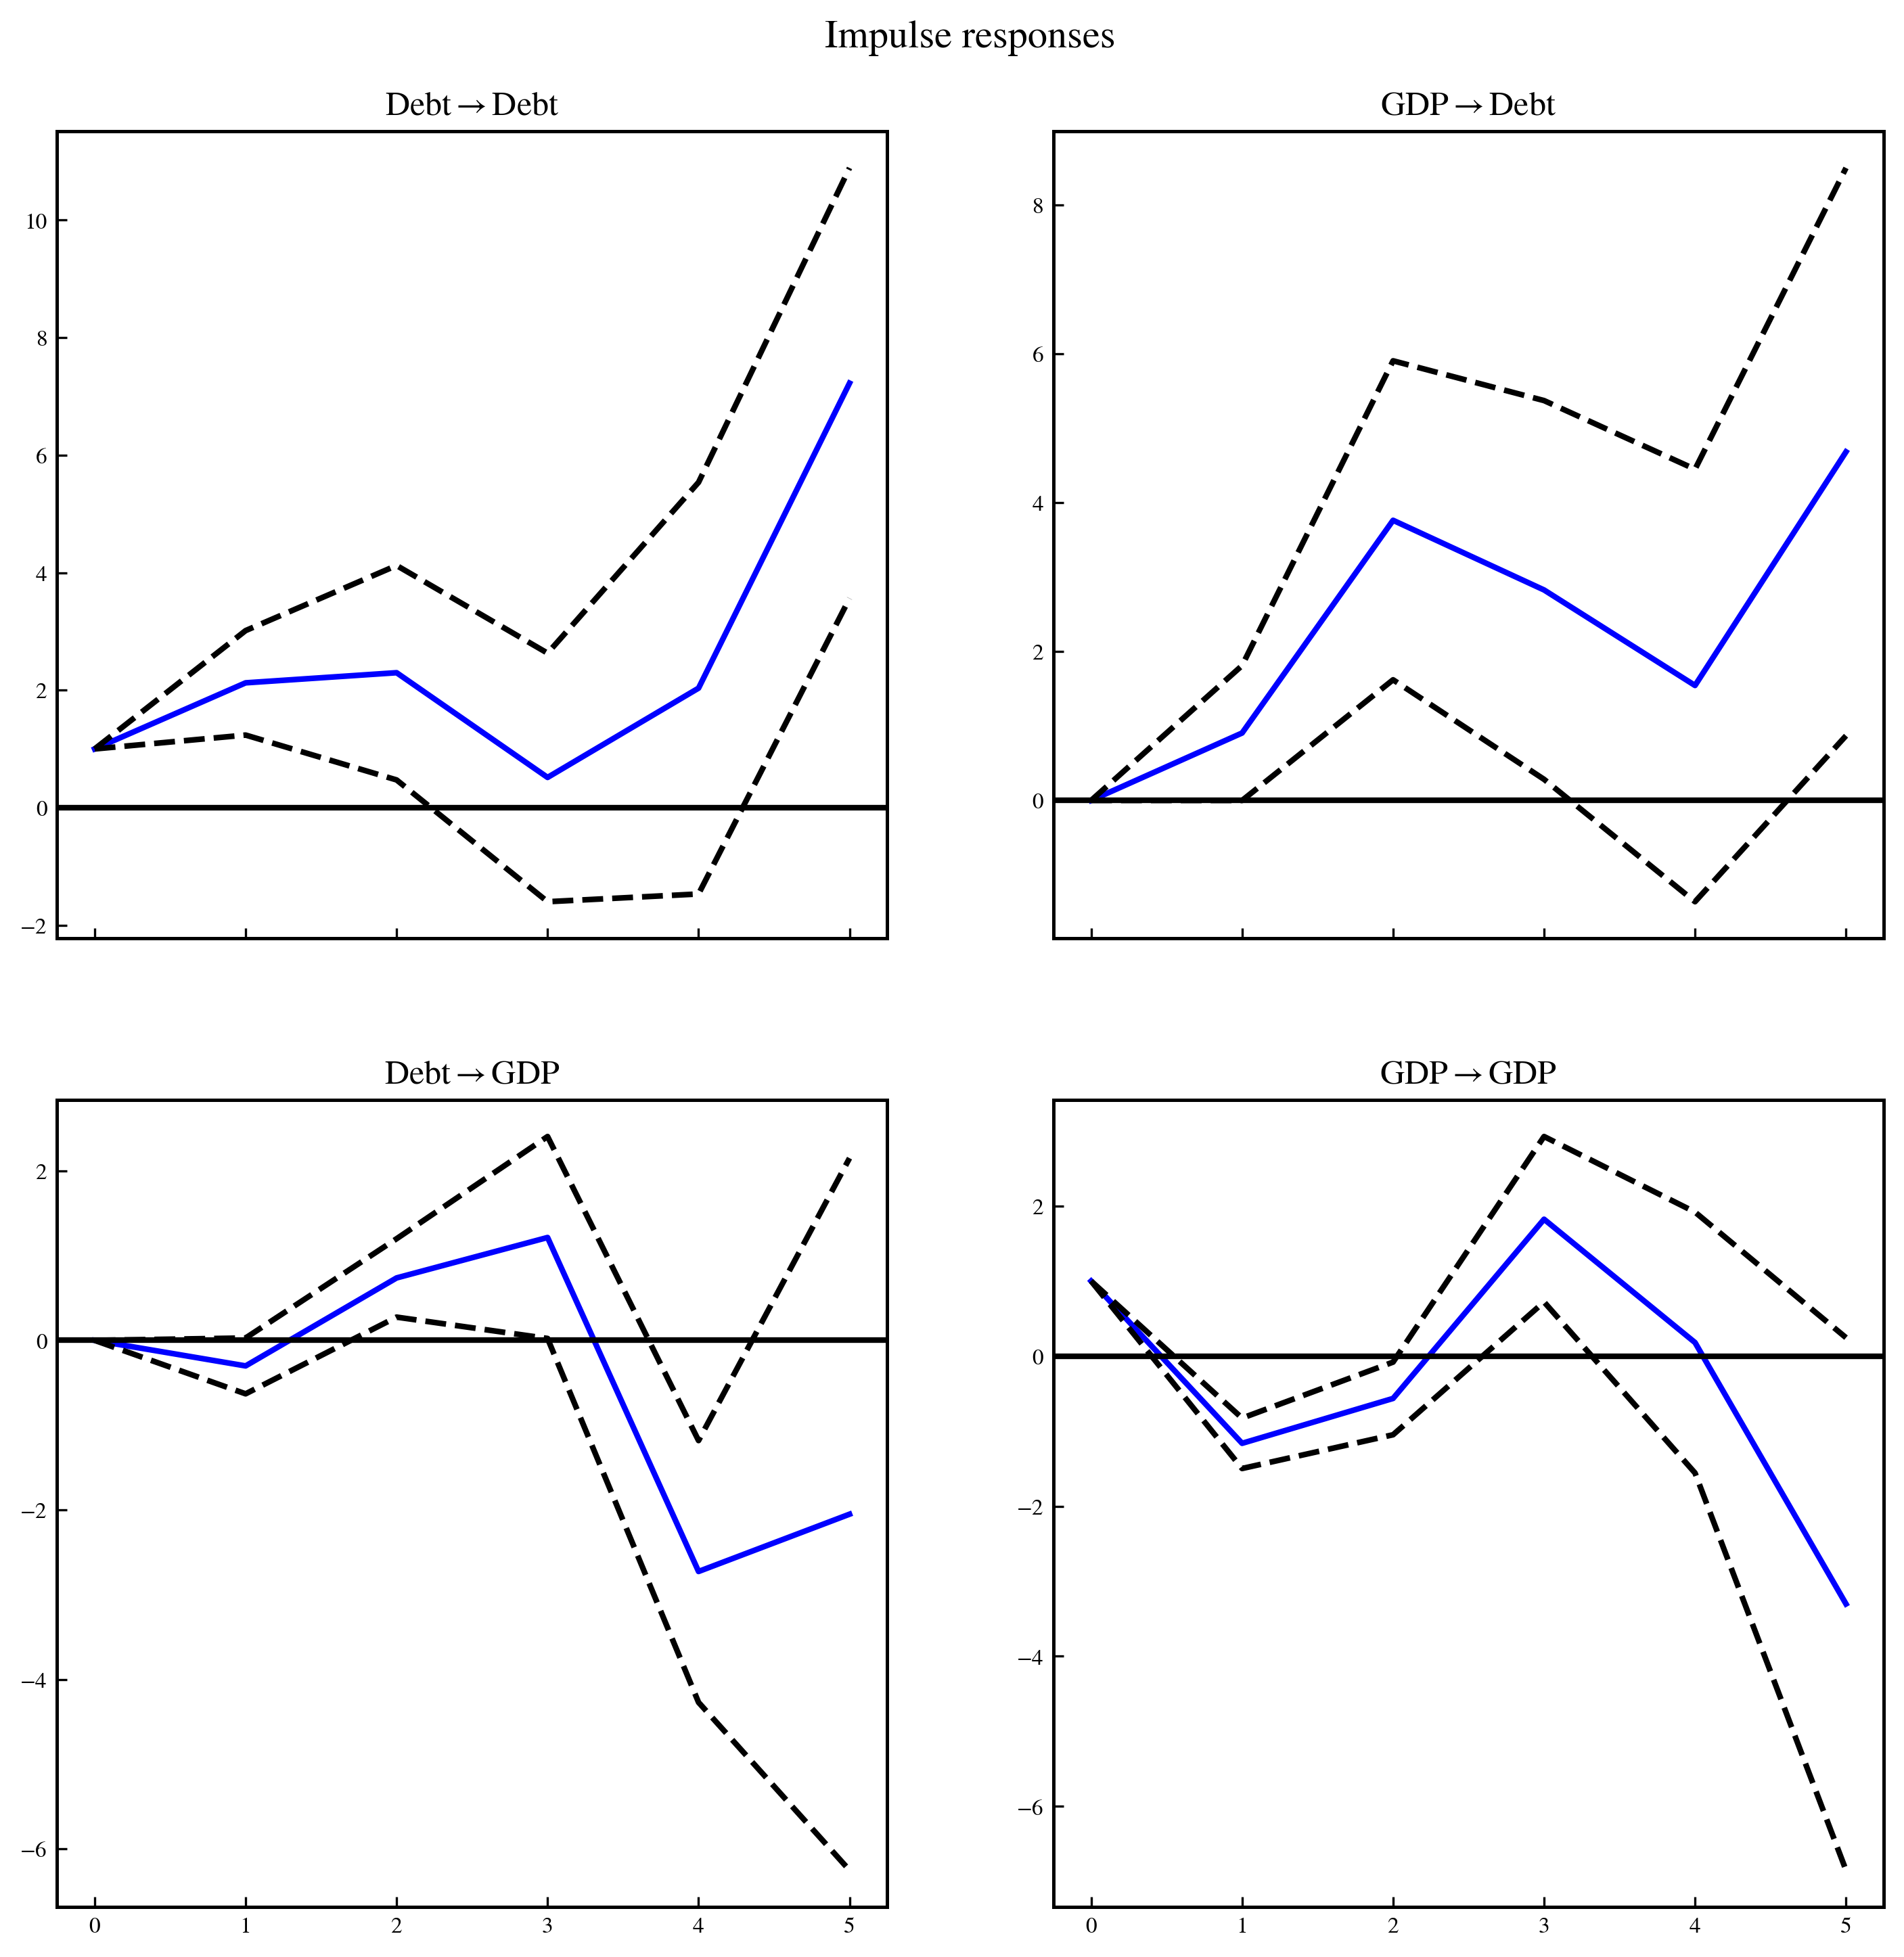

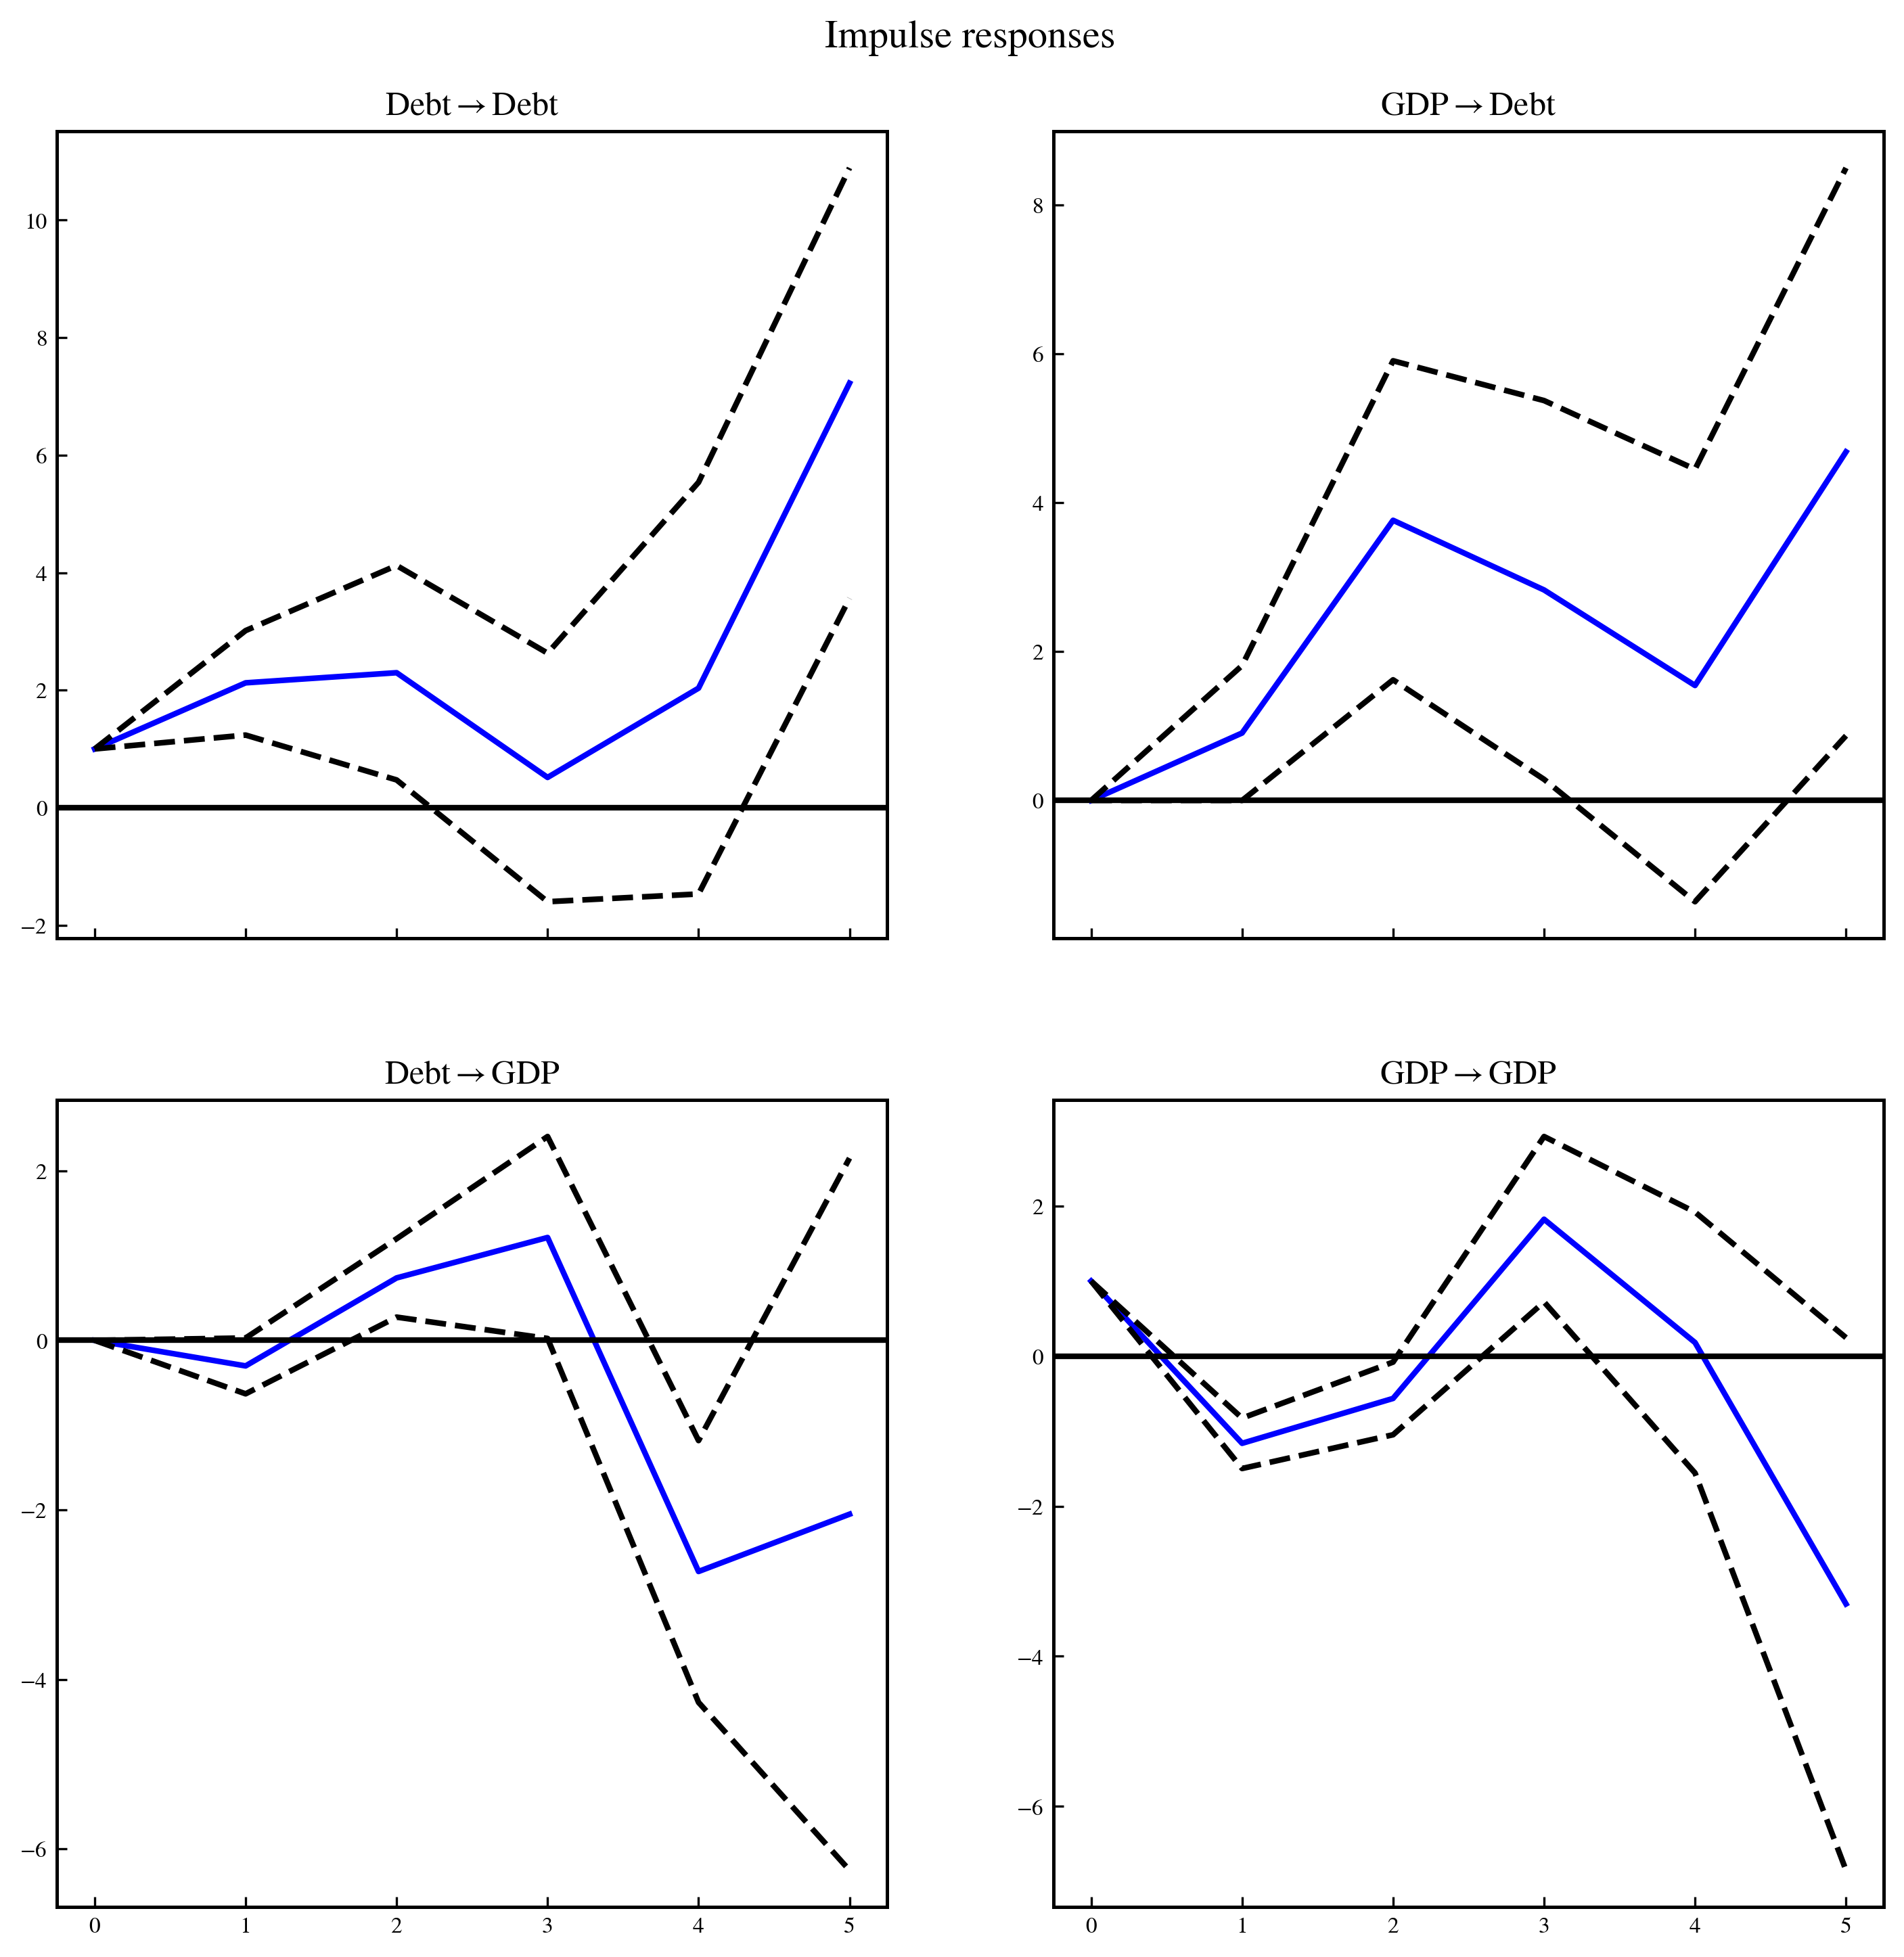

In [240]:
num_periods = 5
ir = vecm_res.irf(periods=num_periods)
ir.plot(plot_stderr=True)